In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from scipy.stats.mstats import mquantiles
from scipy.stats import beta
from scipy.stats import linregress

In [2]:
sum_stat = '/f/jianhua/nankai-hic/fine-mapping/prostate_cancer.txt'
chrom, bp, p = 'CHR','BP','P'
sep = '\t'
df = pd.read_csv(sum_stat,sep=sep)

FileNotFoundError: [Errno 2] No such file or directory: '/f/jianhua/nankai-hic/fine-mapping/prostate_cancer.txt'

# Reduce size

In [19]:
df['CHR'] = df['CHR'].replace('X',23)
df['CHR'] = df['CHR'].astype(int)
df['P'] = -np.log10(df['P'])
df['P_down'] = df['P'].round(1)
df['P'] = df['P'].round(3)
df['BP_down'] = df['BP']/5e6
df['BP_down'] = df['BP_down'].astype(int)
idx = np.random.permutation(np.arange(len(df)))
df = df.iloc[idx].drop_duplicates(['CHR','P_down','BP_down'])
df = df.sort_values(['CHR','BP'])
df['P'] = 10 ** -df['P']

In [12]:
def qq(data,ax,color):
    xmax = 0
    ymax = 0
    alpha = 0.9
    color = '#000000'
    n_quantiles = 100

    q_pos = np.concatenate([
        np.arange(99.) / len(data),
        np.logspace(-np.log10(len(data)) + 2, 0, n_quantiles)
    ])

    q_data = mquantiles(data, prob=q_pos, alphap=0, betap=1, limit=(0, 1))
    q_th = q_pos.copy()
    q_err = np.zeros([len(q_pos), 2])
    for i in range(0, len(q_pos)):
        q_err[i, :] = q_err[i, :] = beta.interval(
            alpha,
            len(data) * q_pos[i],
            len(data) - len(data) * q_pos[i])

    q_err[i, q_err[i, :] < 0] = 1e-15
    slope, intercept, r_value, p_value, std_err = linregress(q_th, q_data)
    xmax = np.max([xmax, -np.log10(q_th[1])])
    ymax = np.max([ymax, -np.log10(q_data[0])])

    ax.plot(
        -np.log10(q_th[n_quantiles - 1:]),
        -np.log10(q_data[n_quantiles - 1:]),
        '-',
        color=color)
    ax.plot(
        -np.log10(q_th[:n_quantiles]),
        -np.log10(q_data[:n_quantiles]),
        '.',
        color=color,
        label='gf')
    ax.plot([0, xmax], [0, xmax], '--k',color='#f42e30')
    ax.fill_between(
        -np.log10(q_th),
        -np.log10(q_err[:, 0]),
        -np.log10(q_err[:, 1]),
        color=color,
        alpha=0.1,
    )

In [16]:
def manhattan(df,ax):
    df[p] = -np.log10(df[p])
    df = df.sort_values(chrom)
    df_grouped = df.groupby((chrom))

    colors = ['#1A1A1A','#999999',]
    x_labels = []
    x_labels_pos = []
    end = 1000
    for num, (name, group) in enumerate(df_grouped):
        group[bp] = group[bp] + end
        end = group[bp].max() + 1000
        ax.scatter(group[bp], group[p],c=colors[num % len(colors)],s=1)
        x_labels.append(name)
        x_labels_pos.append(group[bp].mean())
    ax.axhline(y=-np.log10(5e-8), color='#2222FF', linestyle='-')
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
#     print(df.loc[0,bp]-len(df)*0.1,end+len(df)*0.1)
#     ax.set_ylim([-0.5, df[p].max()*1.05])

/f/jianhua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/f/jianhua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/f/jianhua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/f/jianhua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


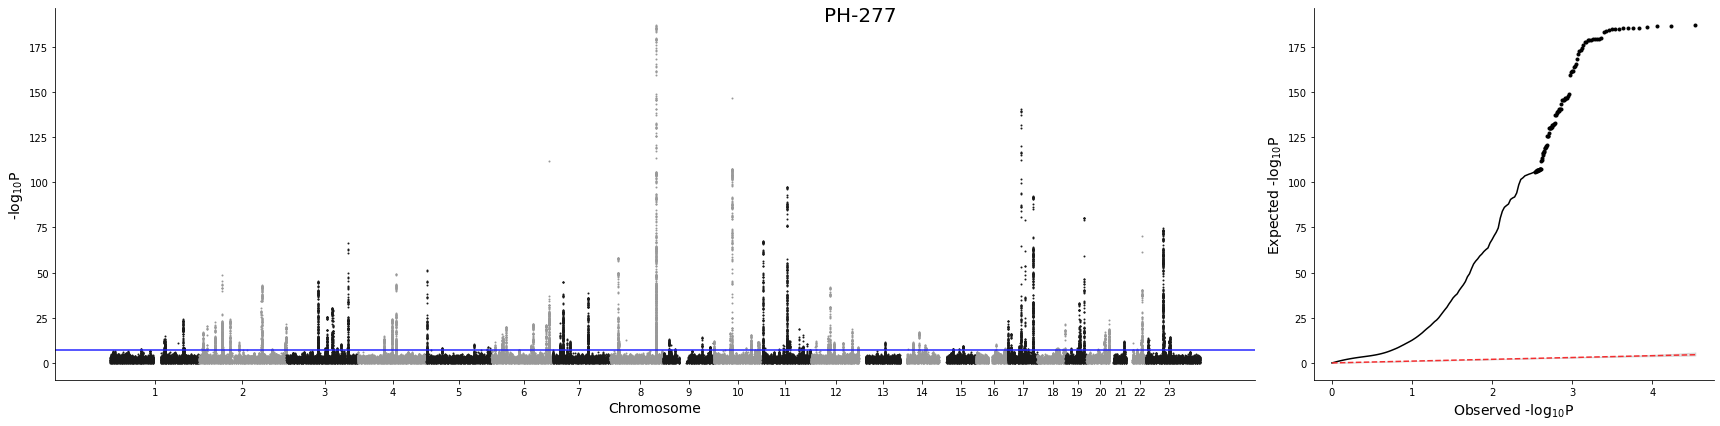

In [20]:
# df = alldf.copy()
figure_tile = 'PH-277'
fig = plt.figure(figsize=(24, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
qq(df[p], ax1, 'b')
manhattan(df,ax0)
# ax0.set_xlim(left=-3e7,right=2.9e9)
ax0.set_xlabel('Chromosome', fontsize=14)
ax0.set_ylabel('-$\mathregular{log_{10}}$P', fontsize=14)
ax1.set_xlabel('Observed -$\mathregular{log_{10}}$P', fontsize=14)
ax1.set_ylabel('Expected -$\mathregular{log_{10}}$P', fontsize=14)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.suptitle(figure_tile, fontsize=20)
fig.tight_layout()
fig.savefig('{}_Manhattan_QQ.pdf'.format(figure_tile), dpi=300)